<a href="https://colab.research.google.com/github/Shaw2711/Machine-Learning---CT4101/blob/main/CT4101%2B_%2BAssignment%2B2%2BSai_Shasank_Dandu_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [6]:
#Initialising the required variables
RANDOM_STATE = 42
N_FOLDS = 10
CV = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [7]:
#Loading Dataset
df = pd.read_csv("steel.csv")
print("shape:", df.shape)
display(df.head())
print("\nColumn dtypes:")
print(df.dtypes)

shape: (553, 10)


,normalising_temperature,tempering_temperature,percent_silicon,percent_chromium,percent_copper,percent_nickel,percent_sulphur,percent_carbon,percent_manganese,tensile_strength
0,178.500,275,0.1530,0.970575,0.942,0.8870,0.0,1.920,0.0,25.107613
1,178.500,950,0.1530,1.212726,0.942,0.8870,0.0,1.920,0.0,140.035334
2,178.500,375,0.1530,1.621165,0.942,0.8870,0.0,1.920,0.0,42.217650
3,178.500,900,0.1530,0.809989,0.942,0.8870,0.0,1.920,0.0,95.015309
4,189.525,900,0.1624,1.036229,0.849,0.9382,0.0,2.035,0.0,113.266773



Column dtypes:
normalising_temperature    float64
tempering_temperature        int64
percent_silicon            float64
percent_chromium           float64
percent_copper             float64
percent_nickel             float64
percent_sulphur            float64
percent_carbon             float64
percent_manganese          float64
tensile_strength           float64
dtype: object


In [9]:
#arranging the target column
TARGET = "tensile_strength"
assert TARGET in df.columns, f"Target column {TARGET} not found in dataset."

# Selection of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != TARGET]
print("\nUsing features:", features)
print("Target:", TARGET)


Using features: ['normalising_temperature', 'tempering_temperature', 'percent_silicon', 'percent_chromium', 'percent_copper', 'percent_nickel', 'percent_sulphur', 'percent_carbon', 'percent_manganese']
Target: tensile_strength


In [10]:
#Summary statistics of the data set with target variable
display(df[features + [TARGET]].describe().T)

,count,mean,std,min,25%,50%,75%,max
normalising_temperature,553.0,478.205222,162.317845,178.500000,382.987500,465.850000,570.500000,945.000000
tempering_temperature,553.0,752.124774,259.220817,225.000000,550.000000,900.000000,900.000000,950.000000
percent_silicon,553.0,0.063890,0.080655,0.000000,0.000000,0.000000,0.129800,0.359400
percent_chromium,553.0,1.277492,0.260280,0.745783,1.065888,1.286314,1.492220,1.794173
percent_copper,553.0,0.784018,0.068589,0.594000,0.753450,0.784000,0.830000,0.945000
percent_nickel,553.0,0.972592,0.074270,0.801000,0.932000,0.968000,1.028100,1.125000
percent_sulphur,553.0,0.059302,0.055396,0.000000,0.000000,0.061000,0.101000,0.322000
percent_carbon,553.0,1.817157,0.185422,1.378000,1.680800,1.857000,1.920000,2.470000
percent_manganese,553.0,0.577192,0.623316,0.000000,0.000000,0.244600,1.175400,1.950000
tensile_strength,553.0,192.048148,91.134383,12.824943,126.201687,182.556353,245.501719,454.295736


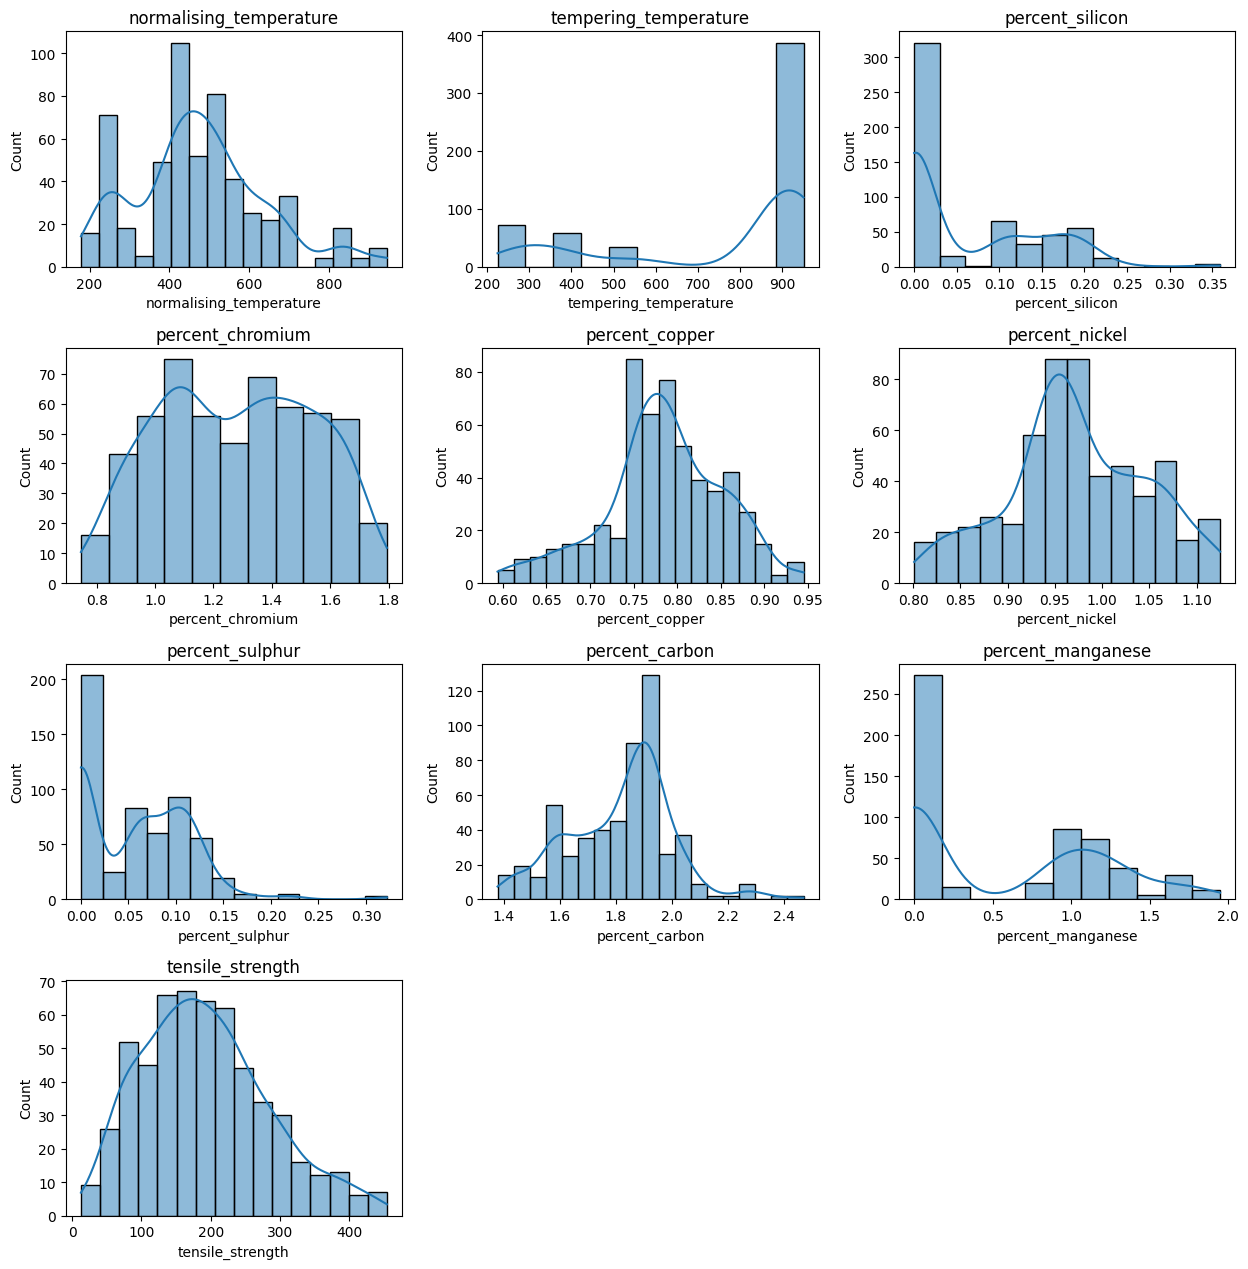

In [11]:
#Histogram visualization of data features before tuning
ncols = 3
nplots = len(features) + 1
nrows = int(np.ceil(nplots / ncols))
plt.figure(figsize=(ncols * 4.2, nrows * 3.2))
for i, col in enumerate(features + [TARGET], start=1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

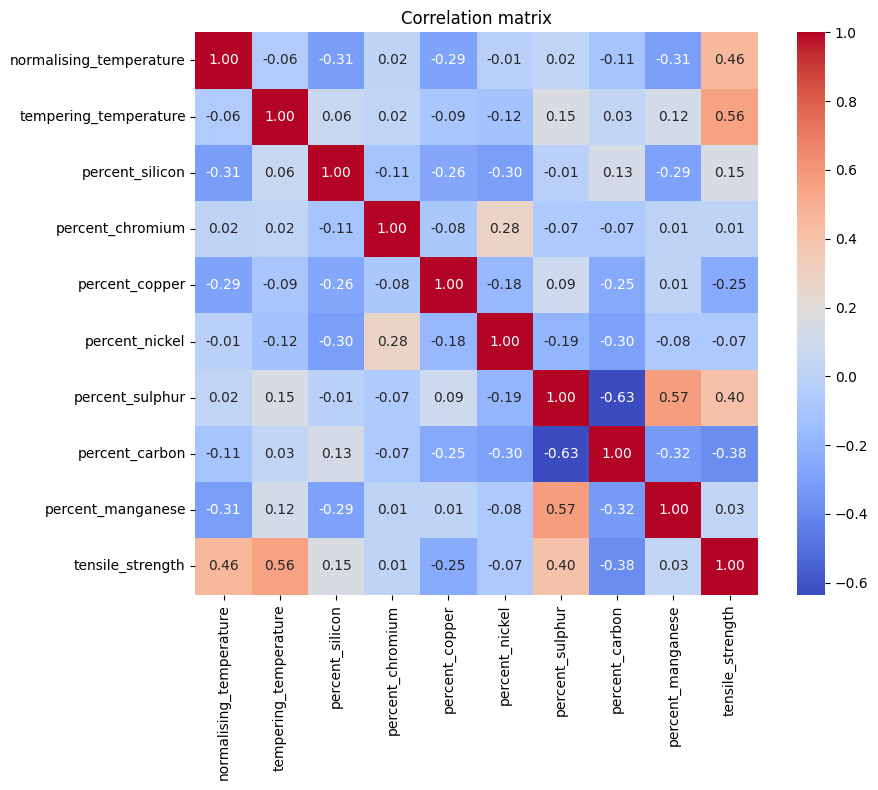

In [12]:
#Heatmap visualization giving correlation analysis of data features
plt.figure(figsize=(10, 8))
corr = df[features + [TARGET]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

In [13]:
#Declaration of variables X with features and y with target
X = df[features].copy()
y = df[TARGET].copy()


In [16]:
#Performing 10 fold crossvalidation with data set and splitting the dataset into train and test data
pipe_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingRegressor(random_state=RANDOM_STATE))
])

pipe_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])
scoring = {
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error',
    'r2': 'r2'
}

def summarize_cv_results(cv_res):
    "Converting cross_validate result into dictionary into average positive metrics."
    train_mse = -cv_res['train_mse']
    test_mse = -cv_res['test_mse']
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = -cv_res['train_mae']
    test_mae = -cv_res['test_mae']
    train_mape = np.abs(cv_res['train_mape'])
    test_mape = np.abs(cv_res['test_mape'])
    train_r2 = cv_res['train_r2']
    test_r2 = cv_res['test_r2']
    return {
        'train_RMSE_mean': train_rmse.mean(),
        'train_RMSE_std': train_rmse.std(),
        'test_RMSE_mean': test_rmse.mean(),
        'test_RMSE_std': test_rmse.std(),
        'train_MAE_mean': train_mae.mean(),
        'test_MAE_mean': test_mae.mean(),
        'train_MAPE_mean': train_mape.mean(),
        'test_MAPE_mean': test_mape.mean(),
        'train_R2_mean': train_r2.mean(),
        'test_R2_mean': test_r2.mean()
    }

print("\nEvaluating default GradientBoostingRegressor (10-fold CV)...")
gb_cv = cross_validate(pipe_gb, X, y, cv=CV, scoring=scoring, return_train_score=True, n_jobs=-1)
gb_default_summary = summarize_cv_results(gb_cv)
print(pd.Series(gb_default_summary).round(4))

print("\nEvaluating default SVR (10-fold CV)...")
svr_cv = cross_validate(pipe_svr, X, y, cv=CV, scoring=scoring, return_train_score=True, n_jobs=-1)
svr_default_summary = summarize_cv_results(svr_cv)
print(pd.Series(svr_default_summary).round(4))



Evaluating default GradientBoostingRegressor (10-fold CV)...
train_RMSE_mean    16.9457
train_RMSE_std      0.3338
test_RMSE_mean     27.5056
test_RMSE_std       5.0485
train_MAE_mean     12.6222
test_MAE_mean      20.0470
train_MAPE_mean     0.0765
test_MAPE_mean      0.1224
train_R2_mean       0.9653
test_R2_mean        0.9020
dtype: float64

Evaluating default SVR (10-fold CV)...
train_RMSE_mean    79.1681
train_RMSE_std      1.5210
test_RMSE_mean     78.6247
test_RMSE_std      13.8449
train_MAE_mean     61.7390
test_MAE_mean      62.5816
train_MAPE_mean     0.4747
test_MAPE_mean      0.4815
train_R2_mean       0.2437
test_R2_mean        0.2344
dtype: float64


In [17]:
# Hyperparameter Tuning (GridSearchCV)
# GradientBoosting: tuning learning_rate and n_estimators
gb_param_grid = {
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__n_estimators': [50, 100, 200]
}
gb_gs = GridSearchCV(pipe_gb, gb_param_grid, scoring='neg_mean_squared_error', cv=CV, n_jobs=-1)
print("\nRunning GridSearchCV for GradientBoostingRegressor...")
gb_gs.fit(X, y)
print("Best GB params:", gb_gs.best_params_)
gb_best = gb_gs.best_estimator_

# Evaluating tuned GB with 10-fold CV (train + test)
gb_tuned_cv = cross_validate(gb_best, X, y, cv=CV, scoring=scoring, return_train_score=True, n_jobs=-1)
gb_tuned_summary = summarize_cv_results(gb_tuned_cv)
print("Gradient Boosting (tuned) summary:")
print(pd.Series(gb_tuned_summary).round(4))



Running GridSearchCV for GradientBoostingRegressor...
Best GB params: {'gb__learning_rate': 0.1, 'gb__n_estimators': 200}
Gradient Boosting (tuned) summary:
train_RMSE_mean    11.7244
train_RMSE_std      0.4025
test_RMSE_mean     25.7234
test_RMSE_std       4.8551
train_MAE_mean      8.6554
test_MAE_mean      18.3727
train_MAPE_mean     0.0530
test_MAPE_mean      0.1123
train_R2_mean       0.9834
test_R2_mean        0.9147
dtype: float64


In [18]:
# SupportVectorRegression: tuning C and kernel (plus gamma for rbf)
svr_param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__kernel': ['rbf', 'poly'],
    'svr__gamma': ['scale', 'auto']
}
svr_gs = GridSearchCV(pipe_svr, svr_param_grid, scoring='neg_mean_squared_error', cv=CV, n_jobs=-1)
print("\nRunning GridSearchCV for SVR...")
svr_gs.fit(X, y)
print("Best SVR params:", svr_gs.best_params_)
svr_best = svr_gs.best_estimator_

# Evaluating tuned SVR with 10-fold CV (train + test)
svr_tuned_cv = cross_validate(svr_best, X, y, cv=CV, scoring=scoring, return_train_score=True, n_jobs=-1)
svr_tuned_summary = summarize_cv_results(svr_tuned_cv)
print("SVR (tuned) summary:")
print(pd.Series(svr_tuned_summary).round(4))



Running GridSearchCV for SVR...
Best SVR params: {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
SVR (tuned) summary:
train_RMSE_mean    45.2655
train_RMSE_std      0.8225
test_RMSE_mean     47.3399
test_RMSE_std      10.5691
train_MAE_mean     32.5971
test_MAE_mean      36.1204
train_MAPE_mean     0.2177
test_MAPE_mean      0.2432
train_R2_mean       0.7526
test_R2_mean        0.7205
dtype: float64


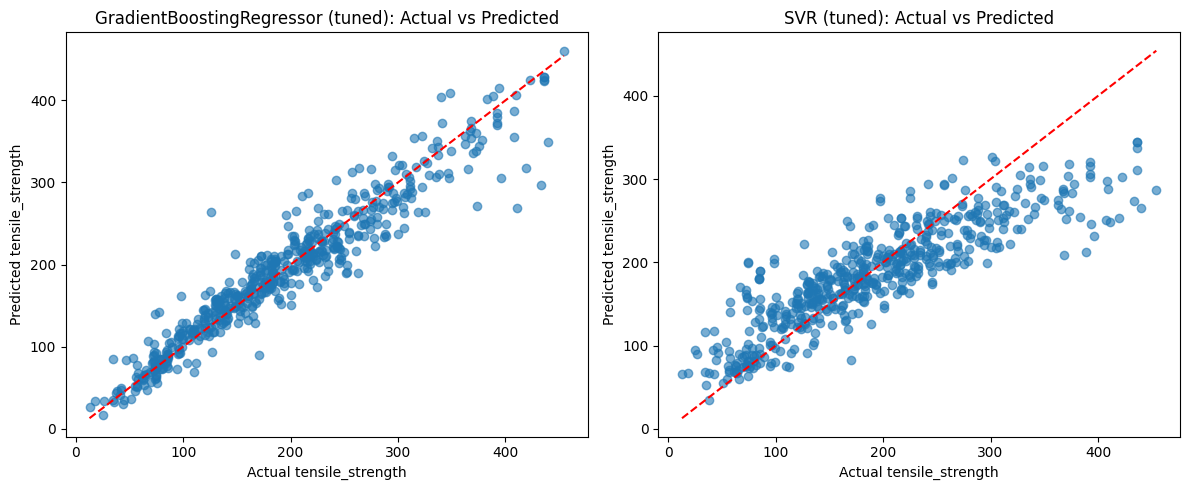

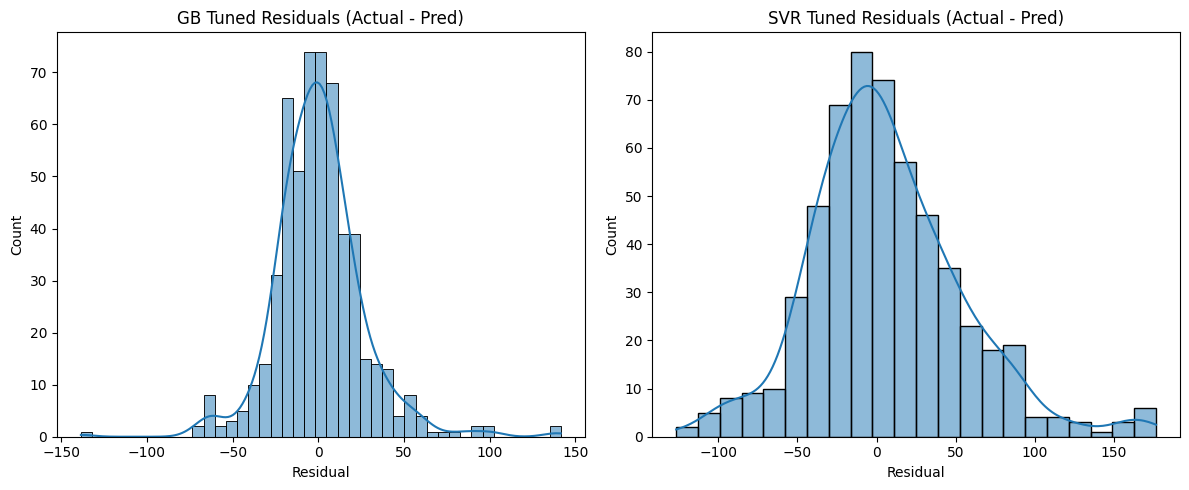

,model,test_RMSE,test_MAPE,test_R2
0,GB_default,27.5056,0.1224,0.9020
1,GB_tuned,25.7234,0.1123,0.9147
2,SVR_default,78.6247,0.4815,0.2344
3,SVR_tuned,47.3399,0.2432,0.7205


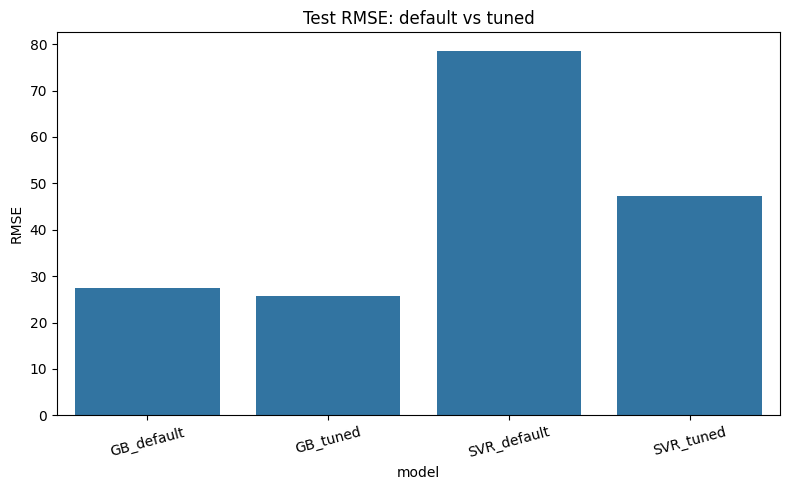

In [19]:
# Cross-validated predictions (After tuning models)
gb_pred = cross_val_predict(gb_best, X, y, cv=CV, n_jobs=-1)
svr_pred = cross_val_predict(svr_best, X, y, cv=CV, n_jobs=-1)

# Scatter: Actual vs Predicted
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y, gb_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual tensile_strength")
plt.ylabel("Predicted tensile_strength")
plt.title("GradientBoostingRegressor (tuned): Actual vs Predicted")

plt.subplot(1,2,2)
plt.scatter(y, svr_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual tensile_strength")
plt.ylabel("Predicted tensile_strength")
plt.title("SVR (tuned): Actual vs Predicted")
plt.tight_layout()
plt.show()

# Residual histograms for both GB and SVR residuals
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(y - gb_pred, kde=True)
plt.title("GB Tuned Residuals (Actual - Pred)")
plt.xlabel("Residual")
plt.subplot(1,2,2)
sns.histplot(y - svr_pred, kde=True)
plt.title("SVR Tuned Residuals (Actual - Pred)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# Comparison of both models with bar chart
summary_df = pd.DataFrame({
    'model': ['GB_default', 'GB_tuned', 'SVR_default', 'SVR_tuned'],
    'test_RMSE': [gb_default_summary['test_RMSE_mean'], gb_tuned_summary['test_RMSE_mean'],
                  svr_default_summary['test_RMSE_mean'], svr_tuned_summary['test_RMSE_mean']],
    'test_MAPE': [gb_default_summary['test_MAPE_mean'], gb_tuned_summary['test_MAPE_mean'],
                  svr_default_summary['test_MAPE_mean'], svr_tuned_summary['test_MAPE_mean']],
    'test_R2': [gb_default_summary['test_R2_mean'], gb_tuned_summary['test_R2_mean'],
                svr_default_summary['test_R2_mean'], svr_tuned_summary['test_R2_mean']]
})
display(summary_df.round(4))

plt.figure(figsize=(8,5))
sns.barplot(data=summary_df, x='model', y='test_RMSE')
plt.title("Test RMSE: default vs tuned")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [20]:
# Print recommended hyperparameters for report

print("Recommended hyperparameters (GridSearchCV results)")
print("GB best params:", gb_gs.best_params_)
print("SVR best params:", svr_gs.best_params_)


Recommended hyperparameters (GridSearchCV results)
GB best params: {'gb__learning_rate': 0.1, 'gb__n_estimators': 200}
SVR best params: {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
